In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.stats import poisson
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../datasets/combined_odds_cleaned.csv")
df['Date'] = pd.to_datetime(df['Date'])
df['Season'] = df['Season'].astype(str)

temporadas_entrenamiento = ['2019-20', '2020-21', '2021-22', '2022-23']
df_train = df[df['Season'].isin(temporadas_entrenamiento)].copy()
df_test = df[df['Season'] == '2023-24'].copy()

equipos = sorted(pd.unique(df_train[['HomeTeam', 'AwayTeam']].values.ravel()))
n = len(equipos)
idx = {team: i for i, team in enumerate(equipos)}


In [2]:
def poisson_bivariante(x, y, lambda1, lambda2, lambda3):
    prob = 0.0
    for z in range(0, min(x, y)+1):
        prob += (poisson.pmf(z, lambda3) *
                 poisson.pmf(x - z, lambda1) *
                 poisson.pmf(y - z, lambda2))
    return max(prob, 1e-10)  # evitar log(0)

In [3]:
def logverosimilitud_bivar(params):
    ataque = params[:n]
    defensa = params[n:2*n]
    gamma = params[2*n]
    lambda_shared = params[2*n + 1]

    if lambda_shared < 0:
        return np.inf  # restringir a valores positivos

    log_lik = 0
    for _, row in df_train.iterrows():
        i = idx[row['HomeTeam']]
        j = idx[row['AwayTeam']]
        g_home = row['FTHG']
        g_away = row['FTAG']

        lambda_home = np.exp(ataque[i] - defensa[j] + gamma)
        lambda_away = np.exp(ataque[j] - defensa[i])
        lambda1 = max(lambda_home - lambda_shared, 1e-5)
        lambda2 = max(lambda_away - lambda_shared, 1e-5)

        p = poisson_bivariante(g_home, g_away, lambda1, lambda2, lambda_shared)
        log_lik += np.log(p)

    return -log_lik

In [4]:
x0 = np.concatenate([
    np.random.normal(0, 0.1, n),   # ataque
    np.random.normal(0, 0.1, n),   # defensa
    [0.1],                         # gamma
    [0.1]                          # lambda_shared inicial
])

bounds = [(-5, 5)] * (2*n) + [(-1, 1), (0.0001, 1.0)]

res = minimize(logverosimilitud_bivar, x0, method='L-BFGS-B', bounds=bounds)

ataque = dict(zip(equipos, res.x[:n]))
defensa = dict(zip(equipos, res.x[n:2*n]))
gamma = res.x[2*n]
lambda_shared = res.x[2*n + 1]

In [8]:
print(lambda_shared)

0.10643378748017625


In [5]:
max_goals = 6
preds = []

for _, row in df_test.iterrows():
    home = row['HomeTeam']
    away = row['AwayTeam']
    if home not in ataque or away not in ataque:
        continue

    lambda_home = np.exp(ataque[home] - defensa[away] + gamma)
    lambda_away = np.exp(ataque[away] - defensa[home])
    lambda1 = max(lambda_home - lambda_shared, 1e-5)
    lambda2 = max(lambda_away - lambda_shared, 1e-5)

    matriz = np.zeros((max_goals, max_goals))
    for i in range(max_goals):
        for j in range(max_goals):
            matriz[i, j] = poisson_bivariante(i, j, lambda1, lambda2, lambda_shared)

    p_home = np.tril(matriz, -1).sum()
    p_draw = np.trace(matriz)
    p_away = np.triu(matriz, 1).sum()

    pred = np.argmax([p_home, p_draw, p_away])
    pred_label = ['H', 'D', 'A'][pred]

    preds.append({
        'HomeTeam': home,
        'AwayTeam': away,
        'FTR_real': row['FTR'],
        'Pred': pred_label
    })

df_preds = pd.DataFrame(preds)

Accuracy: 0.529
F1 Score (macro): 0.395

Classification Report:
               precision    recall  f1-score   support

           A       0.48      0.54      0.51        95
           D       0.00      0.00      0.00        97
           H       0.56      0.87      0.68       150

    accuracy                           0.53       342
   macro avg       0.35      0.47      0.39       342
weighted avg       0.38      0.53      0.44       342



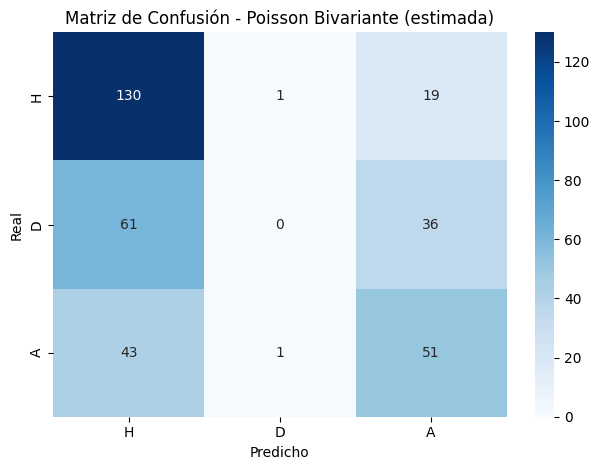

In [6]:
y_true = df_preds['FTR_real']
y_pred = df_preds['Pred']

print("Accuracy:", round(accuracy_score(y_true, y_pred), 3))
print("F1 Score (macro):", round(f1_score(y_true, y_pred, average='macro'), 3))
print("\nClassification Report:\n", classification_report(y_true, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=['H', 'D', 'A'])
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['H', 'D', 'A'], yticklabels=['H', 'D', 'A'])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Poisson Bivariante (estimada)")
plt.tight_layout()
plt.show()

In [11]:
# Simulación de apuestas para modelo Poisson simple

import pandas as pd

# Copiar predicciones
df_apuestas = df_preds.copy()

# Unir cuotas desde df_test usando HomeTeam y AwayTeam
df_apuestas = df_apuestas.merge(
    df_test[['HomeTeam', 'AwayTeam', 'AvgH', 'AvgD', 'AvgA']],
    on=['HomeTeam', 'AwayTeam'],
    how='left'
)

# Definir la cuota usada según la predicción del modelo
df_apuestas['cuota_usada'] = df_apuestas.apply(
    lambda row: row['AvgH'] if row['Pred'] == 'H' else (
        row['AvgD'] if row['Pred'] == 'D' else row['AvgA']
    ),
    axis=1
)

# Calcular si la apuesta fue acertada
df_apuestas['acierto'] = (df_apuestas['Pred'] == df_apuestas['FTR_real']).astype(int)

# Supongamos 1€ apostado por partido
df_apuestas['apostado'] = 1.0
df_apuestas['ganancia'] = df_apuestas['acierto'] * df_apuestas['cuota_usada']

# Resultados agregados
acertadas = df_apuestas['acierto'].sum()
total_partidos = len(df_apuestas)
total_apostado = df_apuestas['apostado'].sum()
total_ganado = df_apuestas['ganancia'].sum()
beneficio_neto = total_ganado - total_apostado
rentabilidad = (beneficio_neto / total_apostado) * 100

# Mostrar resultados
print(f"Apuestas acertadas: {acertadas} de {total_partidos}")
print(f"Total gastado: {total_apostado:.2f} €")
print(f"Total ganado: {total_ganado:.2f} €")
print(f"Beneficio neto: {beneficio_neto:.2f} €")
print(f"Rentabilidad: {rentabilidad:.2f} %")


Apuestas acertadas: 181 de 342
Total gastado: 342.00 €
Total ganado: 570.09 €
Beneficio neto: 228.09 €
Rentabilidad: 66.69 %
